# Suitability Filter Experiments

In [1]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
import torchvision
import torchvision.transforms as transforms
from examples.models.initializer import initialize_torchvision_model
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision.models import ResNet50_Weights, resnet50

import suitability.filter.tests as ftests
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter import suitability

importlib.reload(suitability)

from suitability.filter.suitability import SuitabilityFilter

random.seed(32)
np.random.seed(32)

## Define data and model

In [2]:
root_dir = "/mfsnic/datasets/imagenet/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize(size=(232, 232), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),  # Convert to Tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

imagenet_data = torchvision.datasets.ImageNet(root_dir, split="val", transform=transform)
test, regressor, user = random_split(imagenet_data, [0.25, 0.25, 0.5])
test_data = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)
regressor_data = DataLoader(regressor, batch_size=64, shuffle=True, num_workers=4)

## Initialize suitability filter

In [3]:
suitability_filter = SuitabilityFilter(model, test_data, regressor_data, device)
test_features, test_corr = suitability_filter.get_features(test_data)
suitability_filter.train_regressor()

## Evaluate the suitability filter

### IID Evaluation

In [4]:
dataloader = DataLoader(user, batch_size=64, shuffle=False, num_workers=4)
_, correctness = suitability_filter.get_features(dataloader)

In [5]:
def split_dataset_into_folds(dataset, correctness, n_subsets: int = 10):
    # Define target accuracies
    target_accuracies = np.linspace(0.77, 0.86, n_subsets)
    total_samples = len(correctness)
    
    # Shuffle the indices and the correctness array
    indices = np.random.permutation(total_samples)
    shuffled_correctness = correctness[indices]

    # Initialize subsets
    folds = []
    subsets_correctness = []

    start_idx = 0
    for i, target_accuracy in enumerate(target_accuracies):
        # Calculate the number of correct and incorrect samples needed for the subset
        subset_size = total_samples // n_subsets
        n_correct = int(subset_size * target_accuracy)
        n_incorrect = subset_size - n_correct

        # Find the correct/incorrect samples in the shuffled data
        remaining_correct_indices = np.where(shuffled_correctness[start_idx:] == 1)[0]
        remaining_incorrect_indices = np.where(shuffled_correctness[start_idx:] == 0)[0]

        # Adjust n_correct and n_incorrect based on available samples
        n_correct = min(n_correct, len(remaining_correct_indices))
        n_incorrect = min(n_incorrect, len(remaining_incorrect_indices))

        # Get the actual indices for the current subset
        correct_indices = remaining_correct_indices[:n_correct]
        incorrect_indices = remaining_incorrect_indices[:n_incorrect]

        # Get the final indices for the current subset
        subset_indices = np.concatenate((correct_indices, incorrect_indices)) + start_idx
        
        # Extract the correctness for the current subset
        folds.append(Subset(dataset, indices[subset_indices]))
        subsets_correctness.append(np.mean(shuffled_correctness[subset_indices]))

        # Move the start index forward
        start_idx += len(subset_indices)

    return folds, subsets_correctness

In [6]:
# Construct suitability filter
num_random_tries = 100
num_folds = 10

acs = np.zeros((num_random_tries, num_folds))
corrs = np.zeros((num_random_tries, num_folds))
p_vals = np.zeros((num_random_tries, num_folds))
p_vals_margin = np.zeros((num_random_tries, num_folds))

for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(user, correctness, n_subsets=num_folds)

    for i, fold in enumerate(folds):
        user_data = DataLoader(fold, batch_size=64, shuffle=False, num_workers=4)
        user_features, user_corr = suitability_filter.get_features(user_data)
        acs[j, i] = np.mean(user_features, axis=0)[1]
        corrs[j, i] = np.mean(user_corr)
        test = suitability_filter.suitability_test(user_features=user_features)
        p_vals[j, i] = test['p_value']

In [7]:
test_ac = np.mean(test_features, axis=0)[1]
test_corr = np.mean(test_corr)

In [8]:
x = []
yp = []
ya = []

for i in range(num_folds):
    x.append(corrs[:, i].mean())
    yp.append(np.sum(p_vals[:, i] < 0.05))
    ya.append(np.sum(acs[:, i] > test_ac))

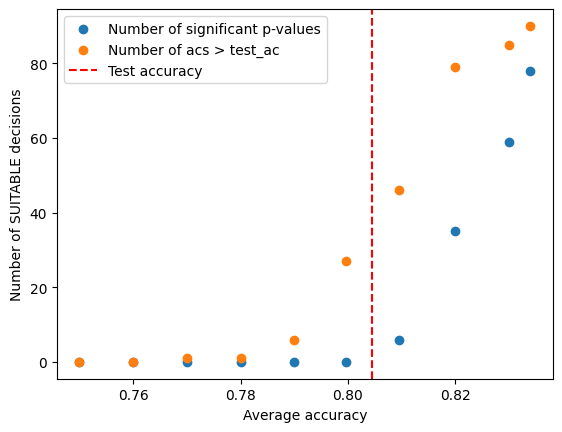

In [10]:
plt.scatter(x, yp, label="Number of significant p-values")
plt.scatter(x, ya, label="Number of acs > test_ac")
plt.xlabel("Average accuracy")
plt.ylabel("Number of SUITABLE decisions")
plt.axvline(test_corr, color='r', linestyle='--', label="Test accuracy")
plt.legend()
plt.show()

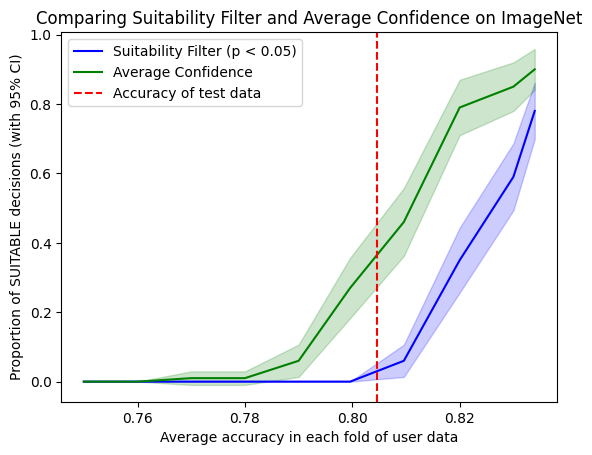

In [16]:
x = []
yp_mean = []
yp_ci = []
ya_mean = []
ya_ci = []

# Loop over folds to calculate the means and 95% CIs for each decision type
for i in range(num_folds):
    avg_accuracy = corrs[:, i].mean()
    x.append(avg_accuracy)

    # Significant p-values decision (p < 0.05)
    p_sig_decision = p_vals[:, i] < 0.05
    p_sig_mean = np.mean(p_sig_decision)
    p_sig_sem = np.std(p_sig_decision) / np.sqrt(len(p_sig_decision))
    p_sig_ci = 1.96 * p_sig_sem  # 95% confidence interval
    yp_mean.append(p_sig_mean)
    yp_ci.append(p_sig_ci)

    # Accuracy exceeds test_ac decision (acs > test_ac)
    ac_exceeds_test = acs[:, i] > test_ac
    ac_exceeds_mean = np.mean(ac_exceeds_test)
    ac_exceeds_sem = np.std(ac_exceeds_test) / np.sqrt(len(ac_exceeds_test))
    ac_exceeds_ci = 1.96 * ac_exceeds_sem  # 95% confidence interval
    ya_mean.append(ac_exceeds_mean)
    ya_ci.append(ac_exceeds_ci)

# Convert lists to arrays for fill_between to work
x = np.array(x)
yp_mean = np.array(yp_mean)
yp_ci = np.array(yp_ci)
ya_mean = np.array(ya_mean)
ya_ci = np.array(ya_ci)

# Plotting
plt.plot(x, yp_mean, label="Suitability Filter (p < 0.05)", color="blue")
plt.fill_between(x, yp_mean - yp_ci, yp_mean + yp_ci, color="blue", alpha=0.2)

plt.plot(x, ya_mean, label="Average Confidence", color="green")
plt.fill_between(x, ya_mean - ya_ci, ya_mean + ya_ci, color="green", alpha=0.2)

plt.xlabel("Average accuracy in each fold of user data")
plt.ylabel("Proportion of SUITABLE decisions (with 95% CI)")
plt.axvline(test_corr, color='r', linestyle='--', label="Accuracy of test data")
plt.title("Comparing Suitability Filter and Average Confidence on ImageNet")
plt.legend()
plt.show()